# Data Analysis Take Home Assessment

## Part 3. Predictive Modeling

#### Task:

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

## Part 1 - EDA:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn import tree, metrics

In [2]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [5]:
def show_na(df):
    na_df = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    na_df.columns=['count', '%']
    na_df.sort_values(by='count', ascending = False)
    return na_df
# Use the function
show_na(df)

,count,%
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_rating_of_driver,8122,16.244
avg_surge,0,0.000
last_trip_date,0,0.000
phone,396,0.792
surge_pct,0,0.000
ultimate_black_user,0,0.000
weekday_pct,0,0.000


In [6]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

max_date = df['last_trip_date'].max()
end_date = max_date - dt.timedelta(days=30)
df['active'] = (df['last_trip_date'] > end_date).astype('int')

active = df[df['active'] == 1]
inactive = df[df['active'] == 0]

ret_per = (len(active)/len(df['active']))*100

print(len(active),",", len(df['active']))
print("Percent of users retained: %.2f" %(ret_per), "%")

18310 , 50000
Percent of users retained: 36.62 %


In [7]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [8]:
show_na(df)

,count,%
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_rating_of_driver,8122,16.244
avg_surge,0,0.000
last_trip_date,0,0.000
phone,396,0.792
surge_pct,0,0.000
ultimate_black_user,0,0.000
weekday_pct,0,0.000


In [9]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
show_na(df)

,count,%
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_rating_of_driver,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
phone,396,0.792
surge_pct,0,0.000
ultimate_black_user,0,0.000
weekday_pct,0,0.000


In [10]:
df_dummied = pd.get_dummies(df, columns = ['city', 'phone'])
df_dummied['ultimate_black_user'] = df_dummied['ultimate_black_user'].map(lambda x: 1 if x == True else 0)
show_na(df_dummied)

,count,%
trips_in_first_30_days,0,0.0
signup_date,0,0.0
avg_rating_of_driver,0,0.0
avg_surge,0,0.0
last_trip_date,0,0.0
surge_pct,0,0.0
ultimate_black_user,0,0.0
weekday_pct,0,0.0
avg_dist,0,0.0
avg_rating_by_driver,0,0.0


In [11]:
df_dummied.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


In [12]:
df_dummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    50000 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   ultimate_black_user     50000 non-null  int64         
 7   weekday_pct             50000 non-null  float64       
 8   avg_dist                50000 non-null  float64       
 9   avg_rating_by_driver    50000 non-null  float64       
 10  active                  50000 non-null  int32         
 11  city_Astapor            50000 non-null  uint8         
 12  city_King's Landing     50000 non-null  uint8 

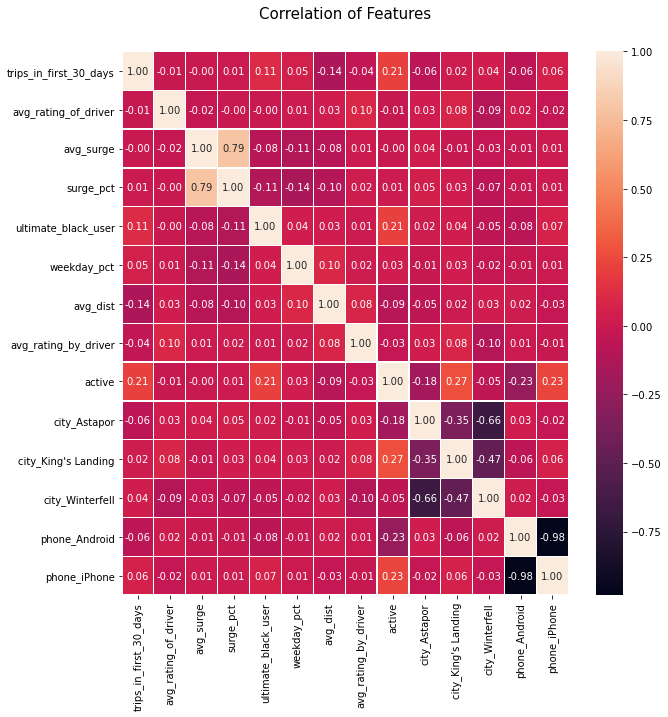

In [13]:
corr = df_dummied.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt='.2f', linewidths=.30)
plt.title('Correlation of Features', y =1.05,  size=15)
pos, textvals = plt.yticks()

In [14]:
df_dummied.drop(['last_trip_date', 'signup_date', 'phone_Android','phone_iPhone', 'surge_pct', 'avg_surge'], inplace=True, axis=1)

In [15]:
df_dummied.head()

,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell
0,4,4.7,1,46.2,3.67,5.0,1,0,1,0
1,0,5.0,0,50.0,8.26,5.0,0,1,0,0
2,3,4.3,0,100.0,0.77,5.0,0,1,0,0
3,9,4.6,1,80.0,2.36,4.9,1,0,1,0
4,14,4.4,0,82.4,3.13,4.9,0,0,0,1


array([[<AxesSubplot:title={'center':'trips_in_first_30_days'}>,
        <AxesSubplot:title={'center':'avg_rating_of_driver'}>,
        <AxesSubplot:title={'center':'ultimate_black_user'}>],
       [<AxesSubplot:title={'center':'weekday_pct'}>,
        <AxesSubplot:title={'center':'avg_dist'}>,
        <AxesSubplot:title={'center':'avg_rating_by_driver'}>],
       [<AxesSubplot:title={'center':'active'}>,
        <AxesSubplot:title={'center':'city_Astapor'}>,
        <AxesSubplot:title={'center':"city_King's Landing"}>],
       [<AxesSubplot:title={'center':'city_Winterfell'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

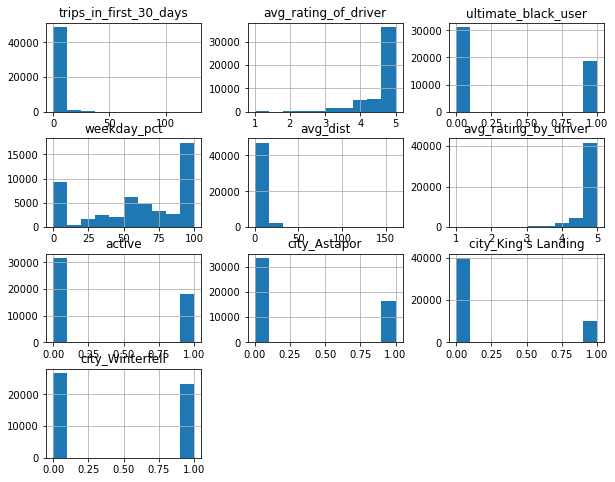

In [16]:
df_dummied.hist(figsize=(10,8))

## Part 2 - Modeling with Random Forest:

In [17]:
from sklearn.preprocessing import StandardScaler

X = df_dummied.drop(columns='active', axis=1)
y = df_dummied['active']

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1995)

(50000, 9) (50000,)


In [18]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=1995)
)

rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.737125, 0.73275 , 0.73675 , 0.740625, 0.74525 ])

In [19]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.7384999999999999, 0.004197469475767494)

In [20]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestclassifier__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [21]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [22]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=1995))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': [10, 12, 16,
                                                                  20, 26, 33,
                                                                  42, 54, 69,
                                                                  88, 112, 143,
                                                                  183, 233, 297,
                                                                  379, 483, 615,
                                                                  784, 1000],
                         'standardscaler': [StandardScaler(), None]})

In [25]:
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 112,
 'standardscaler': StandardScaler()}

In [23]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores, np.mean(rf_best_scores), np.std(rf_best_scores)

(array([0.737125, 0.733375, 0.737125, 0.74275 , 0.7435  ]),
 0.7387750000000001,
 0.003813954640527348)

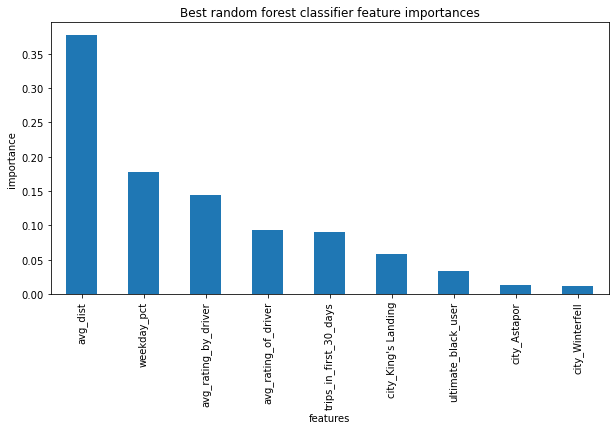

In [24]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

In [40]:
forest=RandomForestClassifier(max_depth= 10, n_estimators=112,random_state=1995)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
y_pred = pd.Series(y_pred)

from sklearn.metrics import classification_report, confusion_matrix
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred,output_dict=True)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" %(result2*100.00))

Confusion Matrix:
[[5465  976]
 [1307 2252]]
Classification Report:
{'0': {'precision': 0.8069994093325458, 'recall': 0.8484707343580189, 'f1-score': 0.8272156209793385, 'support': 6441}, '1': {'precision': 0.6976456009913259, 'recall': 0.6327620118010677, 'f1-score': 0.6636216295859733, 'support': 3559}, 'accuracy': 0.7717, 'macro avg': {'precision': 0.7523225051619358, 'recall': 0.7406163730795433, 'f1-score': 0.7454186252826559, 'support': 10000}, 'weighted avg': {'precision': 0.7680803889439055, 'recall': 0.7717, 'f1-score': 0.7689925194424398, 'support': 10000}}
Accuracy: 77.17%


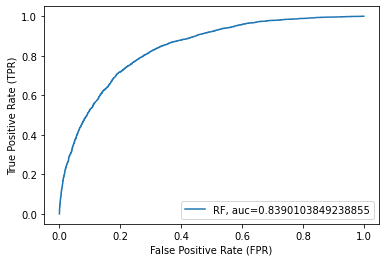

In [41]:
y_pred_proba = forest.predict_proba(X_test)[::,1]
fpr, tpr, _=metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='RF, auc='+str(auc))
plt.xlabel(xlabel='False Positive Rate (FPR)')
plt.ylabel(ylabel='True Positive Rate (TPR)')
plt.legend(loc=4)
plt.show()

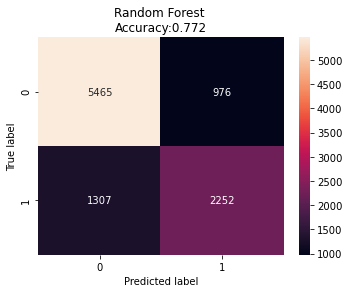

In [42]:
plt.figure(figsize=(5.5,4))
sns.heatmap(result, annot=True, fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<AxesSubplot:>

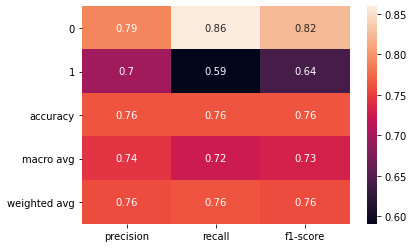

In [38]:
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

In [30]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.796
Accuracy on test set: 0.772


## Part 2.5 -  Modeling w/ XGBoost:

In [32]:
from xgboost import XGBClassifier
XGB =XGBClassifier()
XGB.fit(X_train, y_train)
print(XGB)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:56:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [33]:
y_pred = XGB.predict(X_test)
predictions = [round(value) for value in y_pred]

In [34]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 77.86%


## Part 3 - Results and  Discussions:

Ultimate wants to predict rider retention, and therefore they need to be able to properly predict which customers are most likely to leave the service. The Random Forest Model had an overall accuracy of 77.2%, performing much better on predicting which customers were inactive with ~ 85% accuracy.

This level of accuracy should allow Ultimate to target these inactive customers with marketing campaigns, emails, app notifications, and coupons or discounts.

The best way that Ultimate could use the insights from this model is to review the most important features in predicting for the model. The average distance of the ride and percent of trips occuring during the weekday are the most important, with average rating by driver (the rider's average rating over all of their trips) coming in a close third.

Based off of this information, I would recommend Ultimate to review: 

1. What the average ride distance is and which ones translate into higher activity for customers.

2. Which rides during the weekday make up the majority of their rides and market these rides and times to inactive users with discounts or reminders of service.

3. Encourage driver and customer relations, allowing for cutomers to choose a consistent driver that they  enjoy and providing incentive to drivers for repeat customer rides. This could promote drivers to invest in customers in hopes of creating a repeat rider and earning the incentives that go along with this.